## <center> Predicting Nationality given text</center>

In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib_venn import venn2
import re
import nltk
import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

## Reading Data

I read 10 datasets from disk

In [2]:
numberOfDatasets = 10
def readData(numberOfDatasets, counter):
    df = pd.DataFrame()
    for i in range(counter, counter+numberOfDatasets):
        tempDf = pd.read_csv("./Part"+str(i+1)+".csv")
        df = df.append(tempDf)
    return df

train = readData(numberOfDatasets,0)
train['nationality'] = train['nationality'].astype('category')
print ("Total number of records read : ", len(train))
train.head()

Total number of records read :  472120


,learnerId,nationality,grade,level,topic,text
0,84805,mx,90,5,Summarizing a story,make is a live''s jeans an shit favorit...
1,139062,cn,90,6,Complaining about a meal,19th June 2012I went to a restaurant an...
2,162010,tw,83,6,Writing a movie plot,"Although Isabella had married, but his ..."
3,60036,ru,94,1,Taking inventory in the office,The code of conduct: - do not disclose ...
4,88813,mx,100,8,Describing a business trip,I have fantastic news. Finally I met wi...


In [3]:
test = readData(2, 10)
test['nationality'] = test['nationality'].astype('category')
print ("No. of records read : ", len(test))
test.head()

No. of records read :  94424


,learnerId,nationality,grade,level,topic,text
0,34458,br,90,7,Writing a job advertisement,Open possition for Finance Administrati...
1,136384,mx,79,4,Writing about what you like doing,Hello Dillo. how are you?thank you for ...
2,135078,it,95,3,Replying to a new penpal,"Hi, my names NATASCIA. Im twenty-eight...."
3,21417,ru,100,3,Describing a friend's weekend routine,"On Saturday, he goes swimming at 11:30a..."
4,170106,br,95,1,Writing labels for a clothing store,"This black skirt is 15,00. These red an..."


## Pre-processing

Doing pre-processing of text data:

* lowercase of text
* remove of all puncuation and keeping onl alphanumeric characters
* tokenizing using nltk and re-merging for removal of bad spellings

In [4]:
train['text']=train['text'].apply(lambda x : " ".join(nltk.tokenize.word_tokenize(re.sub(r'\W+', " ", x.lower()))))

test['text']=test['text'].apply(lambda x : " ".join(nltk.tokenize.word_tokenize(re.sub(r'\W+', " ", x.lower()))))

## Building X_train, Y_train, X_test and Y_test

In [5]:
# for k fold only
train = train.head(45000)

X_train, Y_train = train['text'].values, train['nationality'].values
X_test, Y_test = test['text'].values, test['nationality'].values
X_train[0:5]

array(['make is a live s jeans an shit favorit make is the ralp laurens polo is somewhat expensive but i think worth the money mifavorit foot wear is the sport shoe is nike make i think are is berygood quality and comfortables',
       '19th june 2012i went to a restaurant and i had a terrible meal the starter soup was bland the dessert was too sweet the horrible is red wine and coffee was disgusting bitter also the steak was overcooked and there was chilli powder with it it was very unhappy meal sharon',
       'although isabella had married but his husband is very awful and violent so she want to divorce early they were talking very happy after that they are talking on the ship every night day after day john and isabella fall in love and they decide to have an elopement finally they were hold a wedding in other a country and had three children after three years the story have a happy ending',
       'the code of conduct do not disclose confidential information keep your workspace nea

## Converting Y to one-hot

In [6]:
Y_OneHot_Train = pd.get_dummies(Y_train)
Y_OneHot_Test = pd.get_dummies(Y_test)
classes = len(Y_OneHot_Train.columns.values)
Y_OneHot_Train.head()

,ad,ae,af,ai,al,am,ao,aq,ar,as,...,uy,uz,vc,ve,vg,vn,vu,ye,za,zw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
Y_OneHot_Train = Y_OneHot_Train.values
Y_OneHot_Test = Y_OneHot_Test.values
Y_OneHot_Train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Reading GloVe 

In [8]:
def readGlove(filename):   
    with open(filename, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map, words

gloveVecFile = "./glove.6B.50d.txt"
words_to_index, index_to_words, word_to_vec_map, words = readGlove(gloveVecFile)

In [9]:
# Intersection of words in dataset with words in GloVe vector

def getSetOfWords(text) :
    """
    :param : text is an numpy array of strings
    """
    setOfWordsInTrainingDataset = set()
    for sentence in text:
        for word in sentence.split():
            setOfWordsInTrainingDataset.add(word)
    return setOfWordsInTrainingDataset

setOfWordsInTrainingDataset = getSetOfWords(X_train)


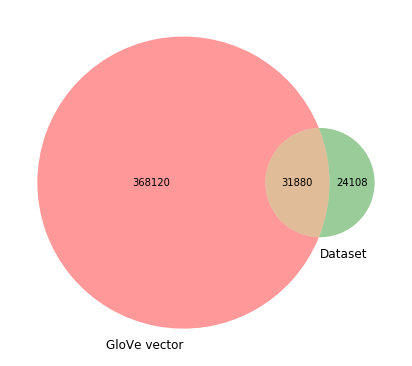

In [10]:
plt.figure(figsize=(7,7))
venn2([words, setOfWordsInTrainingDataset],set_labels = ('GloVe vector', 'Dataset'))
plt.show()
# type(setOfWordsInTrainingDataset)

In [11]:
print (str(150695/(150695+79067))+"% words are not found in GloVe vector")

0.6558743395339526% words are not found in GloVe vector


## Converting sentences to indices vector

In [12]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. One can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros(shape=(m, max_len))
    
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().strip().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except KeyError as e:
                X_indices[i, j] = word_to_index["unk"]
            # Increment j to j + 1
            j = j + 1
            if j>=max_len:
                break
    
    return X_indices

## Defining pre-training embedding layer

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        try:
            emb_matrix[index, :] = word_to_vec_map[word]
        except Exception as e:
            print ("Exception {0} occured for word {1}".format(e, word))

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## Designing model

In [14]:
def nation(input_shape, word_to_vec_map, word_to_index):    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(264)(embeddings)
#     X = LSTM(264)(embeddings)
   
    # Add dropout with a probability of 0.5 to prevent overfitting
    X = Dropout(0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
#     X = LSTM(264)(X)
    
#     # Add dropout with a probability of 0.5
#     X = Dropout(rate = 0.5)(X)

    # Propagate X through a Dense layer with softmax activation to get back a batch of 191-dimensional vectors.
    X = Dense(classes, activation='relu')(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    
    return model

In [15]:
maxLen = 200 # Determined from the EDA notebook
model = nation((maxLen,), word_to_vec_map, words_to_index)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 264)               332640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 191)               50615     
_________________________________________________________________
activation_1 (Activation)    (None, 191)               0         
Total params: 20,383,305.0
Trainable params: 383,255.0
Non-trainable 

In [16]:
## Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
X_train_indices = sentences_to_indices(X_train, words_to_index, maxLen)

## Fitting the model

In [182]:
model.fit(X_train_indices, Y_OneHot_Train, epochs = 1, batch_size = 50, shuffle=True, validation_split=0.2)

Train on 377696 samples, validate on 94424 samples
Epoch 1/1
377696/377696 [==============================] - 8040s - loss: 2.4297 - acc: 0.4028 - val_loss: 2.2747 - val_acc: 0.4159


In [30]:
model.save("./NationalityVsText_v2.hdf5")

## Running model using K-fold cross validation

* Below code is commented. 
* Uncomment and run the below cell to train the model using 10-fold cross validation
* I did not do this, because it was taking too much time - 2 hrs for 1 epoch on 1 validation data
* Feel free to change number of epochs

In [29]:
seed = 8
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, Y_train):
    # Fit the model
    X_train_indices = sentences_to_indices(X_train[train], words_to_index, maxLen)
    Y_OneHot_Train = pd.get_dummies(Y_train[train]).values
    
    model = nation((maxLen,), word_to_vec_map, words_to_index)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print (model.fit(X_train_indices, Y_OneHot_Train, epochs=2, batch_size=50, verbose=1))
    
    # evaluate the model
    X_test_indices = sentences_to_indices(X_train[test], words_to_index, maxLen)
    pred = model.predict(X_test_indices, verbose=1)
    Y_test_pred = np.argmax(pred, axis=1)
    Y_test_map = {}
    for index, country in enumerate(Y_train[train].categories.values):
        Y_test_map[country] = index
    Y_test_actual= []
    for value in Y_train[test]:
        Y_test_actual.append(Y_test_map.get(value))
        
    scores= np.mean(np.equal(Y_test_actual, Y_test_pred))
    print("acc: %.2f%%" % (100*scores))
    cvscores.append(scores * 100)
print("Final k-fold result : %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

/home/saurabh/miniconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Epoch 1/2
35982/35982 [==============================] - 742s - loss: 2.5593 - acc: 0.3925   
Epoch 2/2
9018/9018 [==============================] - 57s    
acc: 39.88%
Epoch 1/2
35983/35983 [==============================] - 771s - loss: 2.6136 - acc: 0.3944   
Epoch 2/2
9017/9017 [==============================] - 57s    
acc: 39.88%
Epoch 1/2
35988/35988 [==============================] - 690s - loss: 2.5914 - acc: 0.3930   
Epoch 2/2
9012/9012 [==============================] - 57s    
acc: 39.89%
Epoch 1/2
35996/35996 [==============================] - 960s - loss: 2.5645 - acc: 0.3924   
Epoch 2/2
9004/9004 [==============================] - 57s    
acc: 39.93%
Epoch 1/2
36051/36051 [==============================] - 690s - loss: 2.6554 - acc: 0.3929   
Epoch 2/2
8949/8949 [==============================] - 67s    
acc: 40.17%
Final k-fold result : 39.95% (+/- 0.11%)


## Testing the model

Below are some of the metrics on testing data

In [32]:
X_test_indices = sentences_to_indices(X_test, words_to_index, max_len = maxLen)

In [33]:
pred = model.predict(X_test_indices, verbose=1)   

94424/94424 [==============================] - 667s   


In [34]:
pred
Y_test_pred = np.argmax(pred, axis=1)

Y_test_map = {}
for index, country in enumerate(Y_train.categories.values):
    Y_test_map[country] = index
    
def getYTestActual(Y_test_map, Y_test):
    Y_test_actual= []
    for value in Y_test:
        Y_test_actual.append(Y_test_map.get(value))
    return Y_test_actual

Y_test_actual = getYTestActual(Y_test_map, Y_test)

In [239]:
# print ("Below is the confusion matrix for model1: ")
# confusion_matrix(Y_test_actual, Y_test_pred)

In [35]:
len(Y_test_actual), len(Y_test_pred)
print ("Testing set accuracy : {0}%".format(100*np.mean(np.equal(Y_test_actual, Y_test_pred))))

Testing set accuracy : 40.34249767008388%


## Testing the model on any validation data set

* I have created 25 files of approx. 18MB size each. 1-10 are used for training and 11-12 are used for validation
* Provide any File Part number (except 1 - 12, 1-10 is used for training and 11-12 are already used for validation) from 13-25

In [36]:
## Provide any part number for validation
part_no = 22 # user choice
validation_df = pd.read_csv("./Part"+str(part_no)+".csv")
X_validation_indices = sentences_to_indices(validation_df['text'].values, words_to_index, max_len = maxLen)
Y_validation_actual = getYTestActual(Y_test_map, validation_df['nationality'].values)

In [38]:
print ("Loading model from disk ...")
model = load_model("./NationalityVsText_v2.hdf5")
print ("model loaded")
print (model.summary())
pred = model.predict(X_validation_indices, verbose=1) 
Y_validation_pred = np.argmax(pred, axis=1)
print ("Validation set accuracy : {0}%".format(100*np.mean(np.equal(Y_validation_actual, Y_validation_pred))))

Loading model from disk ...
model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 50)           20000050  
_________________________________________________________________
lstm_6 (LSTM)                (None, 264)               332640    
_________________________________________________________________
dropout_6 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 191)               50615     
_________________________________________________________________
activation_6 (Activation)    (None, 191)               0         
Total params: 20,383,305.0
Trainable params: 383,255.0
Non-trainable params: 20,000,050.0
___________